In [1]:
%load_ext autoreload
%autoreload 2

In [110]:
from helpers import *

In [60]:
bs = 64
lm_dls = get_lm_dls(bs)
dls = get_text_classifier_dls(bs, lm_dls)

lm_vocab = lm_dls.vocab
text_classifier_vocab = list(dls.vocab[0]) + list(dls.vocab[1])

lm_dls.show_batch()

,text,text_
0,xxbos,andraponni
1,xxbos,xxup
2,xxup,adt45
3,karnatakaponni,xxbos
4,xxbos,xxup
5,xxup,adt45
6,xxbos,xxup
7,adt45,xxbos
8,adt45,xxbos


# Get HF Text Model

In [195]:
from transformers import BertTokenizer, BertModel, AutoModelForPreTraining

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', seq_length=10)
model = AutoModelForPreTraining.from_pretrained("bert-base-uncased", num_labels=len(text_classifier_vocab))

In [196]:
text = ["Replace me by any text you'd like.", "Replace me by any text you'd like."]
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

output.prediction_logits.shape, output.seq_relationship_logits.shape

(torch.Size([2, 12, 30522]), torch.Size([2, 2]))

In [197]:
encoded_input

{'input_ids': tensor([[ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102],
        [ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

# Create a datablock

In [239]:
indices = list(range_of(df))
np.random.shuffle(indices)

train_sz = int(0.8 * len(indices))

splits = [indices[:train_sz], indices[train_sz:]]
tfms = [
    lambda x: x.variety.lower(), 
    partial(tokenizer, return_tensors='pt', 
            add_special_tokens=True, padding=True, 
            pad_to_multiple_of=7),
]
tfms_label = [lambda x: x.label.lower(), Categorize()]
dsets = Datasets(df, [tfms, tfms_label], splits=splits)

In [240]:
dsets[0]

({'input_ids': tensor([[  101,  4748,  2102, 19961,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0]])},
 TensorCategory(0))

In [241]:
def create_batch(x):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    labels = []
    for row, y in x:
        input_ids.append(row['input_ids'])
        token_type_ids.append(row['token_type_ids'])
        attention_mask.append(row['attention_mask'])
        labels.append(y)
    return (
        {
            'input_ids': torch.stack(input_ids).squeeze(1),
            'token_type_ids': torch.stack(token_type_ids).squeeze(1),
            'attention_mask': torch.stack(attention_mask).squeeze(1),
        },
        tensor(labels)
    )

dls = dsets.dataloaders(bs=bs, seq_len=1, 
                        shuffle=True, device=device,
                        create_batch=create_batch)
x, y = dls.one_batch()
x['input_ids'].shape, x['token_type_ids'].shape, x['attention_mask'].shape, y.shape

(torch.Size([64, 7]),
 torch.Size([64, 7]),
 torch.Size([64, 7]),
 torch.Size([64]))

# Train classifier

In [246]:
class HFTextClassifier(Module):
    def __init__(self):
        self.model = AutoModelForPreTraining.from_pretrained("bert-base-uncased").bert
        self.linear = nn.Linear(self.model.config.hidden_size, len(text_classifier_vocab))
    
    def forward(self, x):
        x = self.model(**x)
        x = self.linear(x.pooler_output)
        return x

SuggestedLRs(steep=0.0004786300996784121, valley=4.365158383734524e-05)

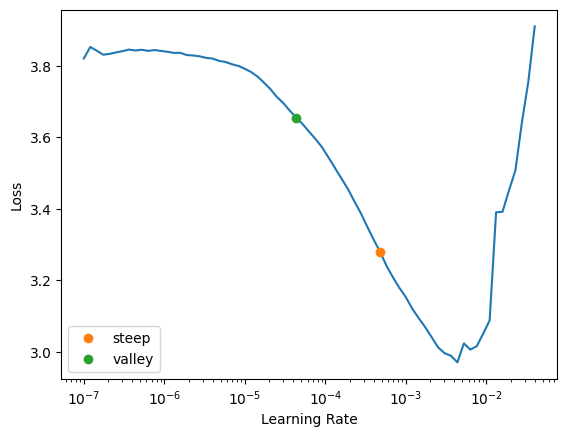

In [247]:
learn = Learner(dls, HFTextClassifier(), metrics=[accuracy], splitter=lambda x: (params(x.model), params(x.linear)))
learn.lr_find(suggest_funcs=(steep, valley))

In [249]:
lr = 5e-4

learn.freeze_to(-1)
learn.fit_one_cycle(1, lr)

learn.unfreeze()
learn.fit_one_cycle(3, lr/2)

epoch,train_loss,valid_loss,accuracy,time
0,2.171323,2.062184,0.244957,00:36


epoch,train_loss,valid_loss,accuracy,time
0,1.975538,1.944403,0.303074,00:39
1,2.155164,2.157429,0.170509,00:39
2,2.160076,2.154014,0.163785,00:39


# Try with non-linearity on classifier

SuggestedLRs(steep=0.0002290867705596611, valley=7.585775892948732e-05)

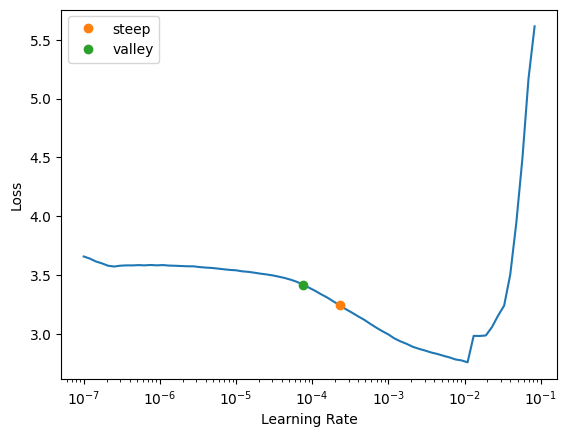

In [250]:
class HFTextClassifier2(Module):
    def __init__(self):
        self.model = AutoModelForPreTraining.from_pretrained("bert-base-uncased").bert
        self.linear = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.model.config.hidden_size, len(text_classifier_vocab))
        )
    
    def forward(self, x):
        x = self.model(**x)
        x = self.linear(x.pooler_output)
        return x
    
learn = Learner(dls, HFTextClassifier(), metrics=[accuracy], splitter=lambda x: (params(x.model), params(x.linear)))
learn.lr_find(suggest_funcs=(steep, valley))

In [251]:
lr = 4e-4

learn.freeze_to(-1)
learn.fit_one_cycle(1, lr)

learn.unfreeze()
learn.fit_one_cycle(3, lr/2)

epoch,train_loss,valid_loss,accuracy,time
0,2.122136,2.041496,0.282901,00:37


epoch,train_loss,valid_loss,accuracy,time
0,1.980578,1.961812,0.297791,00:39
1,1.929346,1.911081,0.304515,00:40
2,1.900963,1.899273,0.306436,00:39
